In [27]:
import pandas as pd
import torch
import numpy as np
import yaml
import hydra
from PIL import Image
from matplotlib import pyplot as plt
from huggingface_mae import MAEModel
from mae_utils import unflatten_tokens

In [14]:
channels = []
for i in range(1, 7):
    im = Image.open(f"sample/AA41_s1_{i}.jp2")
    channels.append(np.array(im))

image_array = np.stack(channels, axis=0)
print(image_array.shape)

image_tensor = torch.tensor(image_array)

(6, 512, 512)


In [12]:
self_standardize = torch.nn.InstanceNorm2d(None, affine=False)

Channel 0:


/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


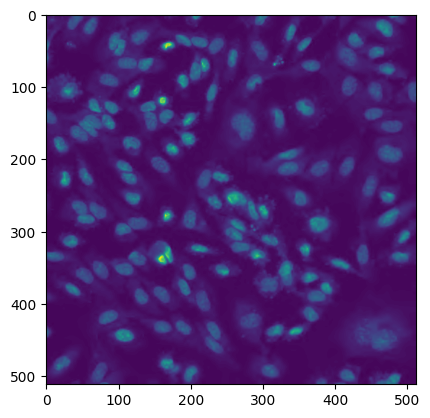

Channel 1:


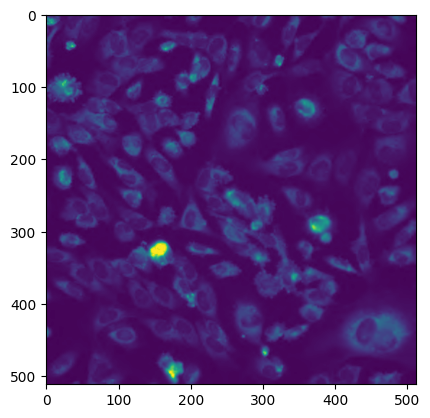

Channel 2:


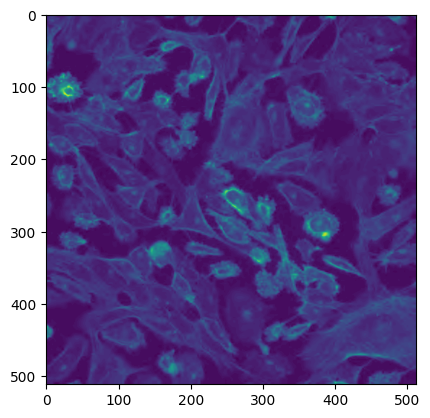

Channel 3:


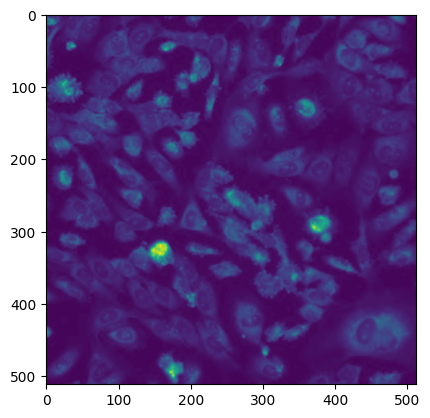

Channel 4:


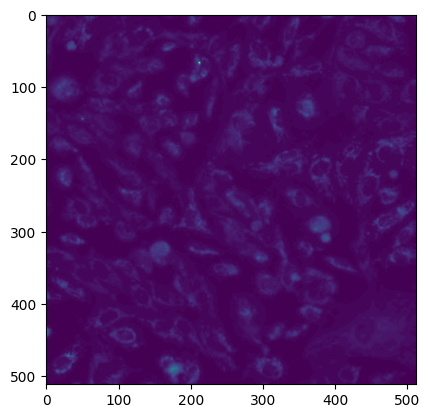

Channel 5:


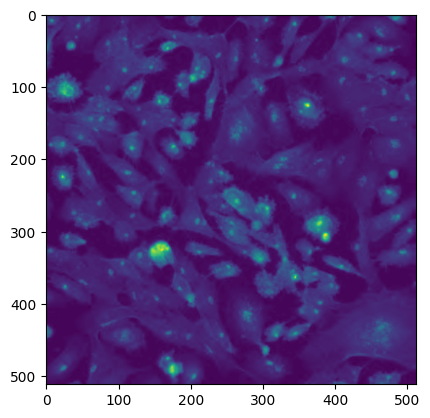

In [17]:
for i in range(6):
    print(f"Channel {i}:")
    plt.imshow(self_standardize(image_tensor.float() / 255).numpy()[i], cmap="viridis")
    plt.show()

In [20]:
huggingface_phenombeta_model_dir = "models/phenom_beta_huggingface"
huggingface_model = MAEModel.from_pretrained(huggingface_phenombeta_model_dir)
huggingface_model = huggingface_model.eval()
huggingface_model.mask_ratio = 0.75  # for example visualization

In [21]:
def cropify(im):
    assert im.shape == (6, 512, 512)
    img = im.view(1, 6, 8, 256, 8, 256)
    img = img.permute(0, 2, 4, 1, 3, 5) 
    return img.reshape(-1, 6, 256, 256)

with torch.inference_mode():
    x = cropify(image_tensor)
    latent, reconstruction, mask = huggingface_model(x)

/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/Users/kian.kd/.pyenv/versions/3.10.0/envs/fm/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


In [22]:
selfstandardizer = torch.nn.modules.InstanceNorm2d(num_features=6, affine=False, track_running_stats=False)


def rescale_intensity(arr: torch.Tensor, bounds=(0.5, 99.5), out_range=(0.0, 1.0)) -> torch.Tensor:
    arr = arr.float() / 255
    sample = arr.flatten()[::100]
    percentiles = torch.quantile(sample, torch.tensor([bounds[0]/100.0, bounds[1]/100.0]))
    arr = torch.clamp(arr, percentiles[0], percentiles[1])
    arr = (arr - percentiles[0]) / (percentiles[1] - percentiles[0])
    arr = arr * (out_range[1] - out_range[0]) + out_range[0]
    return arr


def to_rgb(img: torch.Tensor, dtype=torch.float32) -> torch.Tensor:  # type: ignore[no-untyped-def]
    """Converts a typical photosynthetic image into RGB, assuming the 6-channel cellpaint standard.
    NOTE: to run on CUDA, use the float16 dtype (default assumption); to run on CPU, requires float32."""
    num_channels_required = 6
    b, num_channels, length, width = img.shape  # b x c x l x w
    # Backfill the image arbitrarily with zeros. this could be more faithful to the image if this function
    # knows exactly the channels-to-keep, but the visualization difference would be minor
    # while we would need to propagate that parameter through several classes functions to get here.
    # So instead we approximate by just filling in the image with zeros for missing channels.
    prepped_img = torch.zeros(b, num_channels_required, length, width, dtype=img.dtype, device=img.device)
    if num_channels < num_channels_required:
        prepped_img[:, :num_channels, :, :] += img
    elif num_channels > num_channels_required:
        prepped_img += img[:, :num_channels_required, :, :]
    else:
        prepped_img += img
    # color mapping
    red = [1, 0, 0]
    green = [0, 1, 0]
    blue = [0, 0, 1]
    yellow = [1, 1, 0]
    magenta = [1, 0, 1]
    cyan = [0, 1, 1]
    rgb_map = torch.tensor([blue, green, red, cyan, magenta, yellow], dtype=dtype, device=prepped_img.device)
    rgb_img: torch.FloatTensor = (
        torch.einsum(  # type: ignore[assignment]
            "nchw,ct->nthw",
            prepped_img.to(dtype=dtype),
            rgb_map,
        )
        / 3.0
    )
    _max = rgb_img.max().item()
    _min = rgb_img.min().item()
    return rescale_intensity(rgb_img, bounds=(0.1, 99.9))
    # return rgb_img

In [23]:
from skimage.transform import rescale, resize

In [24]:
crop_size = 256
patch_size = 16

m_r = mask.cpu().numpy()[0]
m_r.shape

(1536,)

In [33]:
z = image_tensor.cpu().numpy()[:, :256, :256]

In [34]:
r = selfstandardizer(
        unflatten_tokens(reconstruction.cpu(), patch_size=16, num_modalities=6, channel_agnostic=True)
    )[0]
r.shape

torch.Size([6, 256, 256])

/var/folders/rh/2pzrb9394871v5556j113wwh0000gr/T/ipykernel_45897/3740770587.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


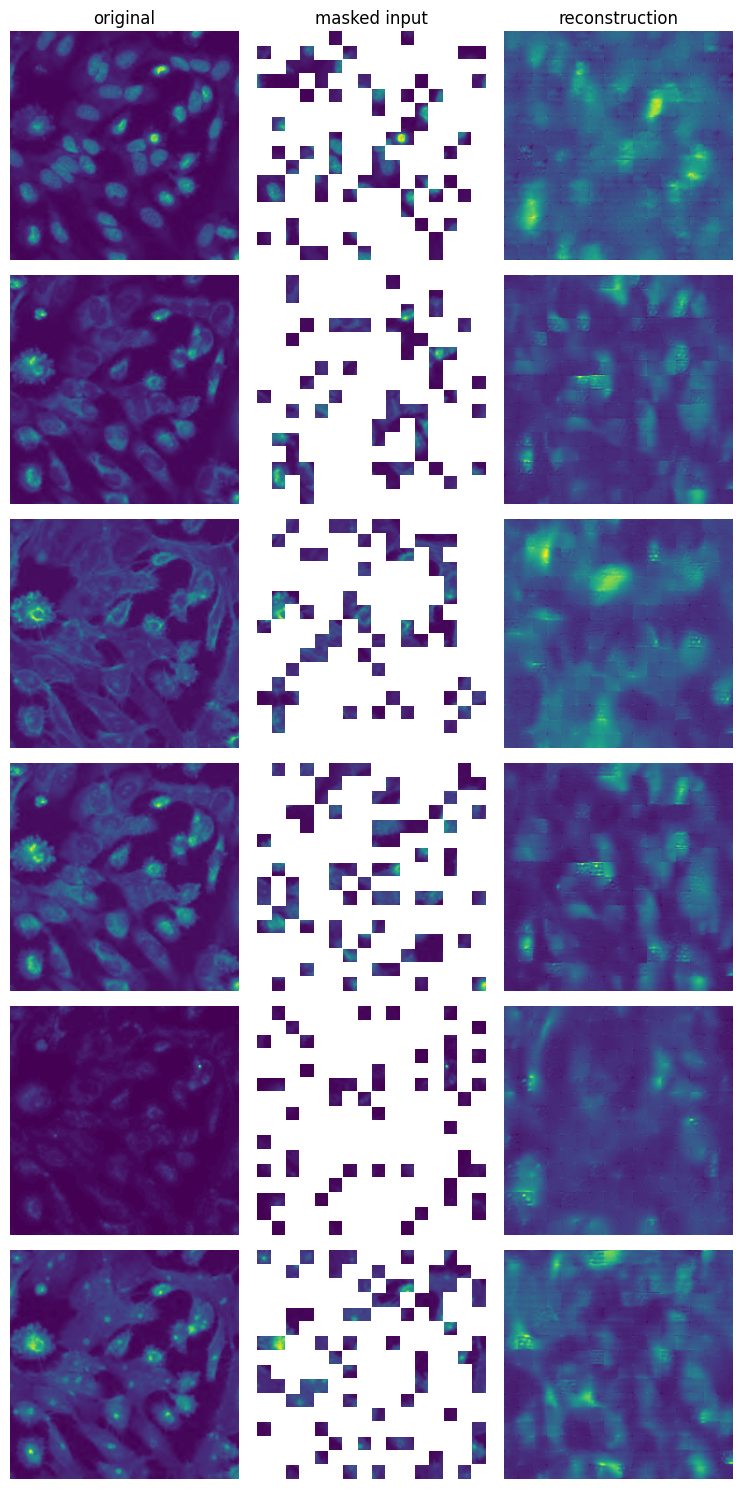

In [35]:
plt.figure(figsize=(12.5,15))
for chan in range(6):
    cmap = 'gray'
    plt.subplot(6,5,1+chan*5)
    plt.imshow(z[chan]);plt.axis('off')
    if chan==0:
        plt.title('original')
        
    plt.subplot(6,5,2+chan*5)
    channel_mask = m_r[chan * patch_size ** 2: (chan + 1) * patch_size ** 2]
    channel_mask = channel_mask.reshape(crop_size//patch_size, crop_size//patch_size)
    channel_mask = resize(channel_mask==1,(crop_size,crop_size))
    plt.imshow(np.ma.masked_where(channel_mask, z[chan]));plt.axis('off')
    if chan==0:
        plt.title('masked input')
        
    plt.subplot(6,5,3+chan*5)
    plt.imshow(r[chan]);plt.axis('off')
    if chan==0:
        plt.title('reconstruction')
        
    # plt.subplot(6,5,5+chan*5)
    # mask_outlines = (nd.morphology.binary_dilation(m_r)^m_r)
    # plt.imshow(mask_outlines==1,'gray');plt.axis('off')
    # plt.imshow(np.ma.masked_where(m_r==False, (zpn[chan]-r[chan])**2));plt.axis('off')
    # # plt.imshow(np.ma.masked_where(m_r==False, np.abs(zpn[chan]-r[chan])));plt.axis('off')
    # if chan==0:
    #     plt.title('reconstruction loss')
    plt.tight_layout()



ORIGINAL (rgb)


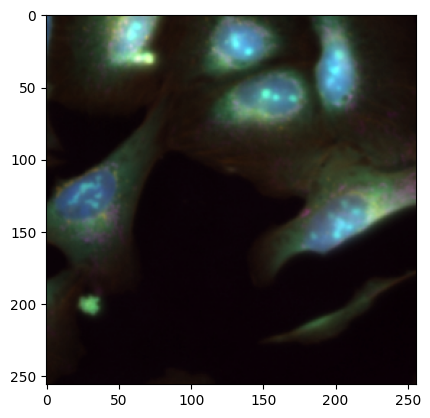

In [23]:
print("ORIGINAL (rgb)")
_ = plt.imshow(to_rgb(torch.tensor(z).unsqueeze(0)).squeeze().transpose(2,0).transpose(0,1))

RECONSTRUCTED (rgb)


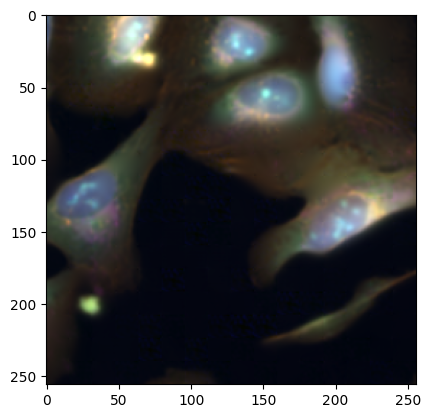

In [24]:
print("RECONSTRUCTED (rgb)")
# def visualize_crop(bf_input_crop, bf_reconstruction_crop, cp_reconstruction_crop):
cp_rgb = to_rgb(
    selfstandardizer(
        model.unflatten_tokens(reconstruction.cpu(), patch_size=16, num_modalities=6)
    )
).cpu().squeeze()
_ = plt.imshow(cp_rgb.transpose(2,0).transpose(0,1))